In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

class IntegerLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        # Initialize weights as floating-point values
        self.weight = nn.Parameter(torch.randn(out_features, in_features, dtype=torch.float32))  # Use normal distribution for initialization
    
    def forward(self, x):
        return torch.mm(x, self.weight.t())
    
    def quantize_weights(self, target_min=--32, target_max=31):
        """Quantize the weights to a target range with dynamic scaling."""
        with torch.no_grad():
            # Find the min and max of the weights
            weight_min = self.weight.min()
            weight_max = self.weight.max()
            
            # Dynamically scale the target range based on observed weight distribution
            scale_factor = 0.3 # Adjust this factor to control how aggressively the weights are scaled
            range_span = (weight_max - weight_min) * scale_factor
            target_min_scaled = weight_min - range_span / 2
            target_max_scaled = weight_max + range_span / 2
            
            # Scale the weights to the scaled target range
            scale = (target_max_scaled - target_min_scaled) / (weight_max - weight_min)
            zero_point = target_min_scaled - weight_min * scale
            
            # Quantize the weights
            quantized_weights = torch.round(self.weight * scale + zero_point)
            
            # Clip the values to ensure they are within the target range
            quantized_weights = torch.clamp(quantized_weights, target_min, target_max)
            
            # Store the quantized weights back into the model
            self.weight.data = quantized_weights
    
class IntegerNet(nn.Module):
    def __init__(self, input_size=784):
        super().__init__()
        # Four layers of IntegerLinear
        self.layer1 = IntegerLinear(input_size, 128)
        self.layer2 = IntegerLinear(128, 128)
        self.layer3 = IntegerLinear(128, 64)
        self.layer4 = IntegerLinear(64, 10)
    
    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.layer3(x)
        x = torch.relu(x)
        x = self.layer4(x)
        return x

    def quantize_weights(self):
        """Quantize weights for all layers."""
        self.layer1.quantize_weights()
        self.layer2.quantize_weights()
        self.layer3.quantize_weights()
        self.layer4.quantize_weights()

In [6]:
def load_data(filepath='train.csv'):
    data = pd.read_csv(filepath)
    labels = data['label'].values
    pixels = data.drop('label', axis=1).values
    
    # Convert to binary (0 or 1)
    pixels = (pixels > 127).astype(np.float32)
    
    return torch.FloatTensor(pixels), torch.LongTensor(labels)

In [7]:
def train_model(model, X_train, y_train, epochs=10, batch_size=128):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
    
    n_samples = X_train.shape[0]
    n_batches = n_samples // batch_size
    
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        
        # Shuffle data
        indices = torch.randperm(n_samples)
        X_train = X_train[indices]
        y_train = y_train[indices]
        
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            
            batch_X = X_train[start_idx:end_idx]
            batch_y = y_train[start_idx:end_idx]
            
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == batch_y).sum().item()
        
        # Print epoch statistics
        avg_loss = total_loss / n_batches
        accuracy = correct / n_samples
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
        
        # Quantize weights after each epoch to reduce their size
        model.quantize_weights()

In [9]:
X_train, y_train = load_data()
model = IntegerNet()

In [10]:
X_train.shape

torch.Size([42000, 784])

In [337]:
train_model(model, X_train, y_train)

Epoch [1/10], Loss: 236.2272, Accuracy: 0.3083
Epoch [2/10], Loss: 11.6330, Accuracy: 0.1227
Epoch [3/10], Loss: 14.5360, Accuracy: 0.1112
Epoch [4/10], Loss: 16.4991, Accuracy: 0.1039
Epoch [5/10], Loss: 15.7448, Accuracy: 0.1023
Epoch [6/10], Loss: 14.8864, Accuracy: 0.1000
Epoch [7/10], Loss: 13.2210, Accuracy: 0.0992
Epoch [8/10], Loss: 25.8806, Accuracy: 0.0989
Epoch [9/10], Loss: 19.4008, Accuracy: 0.0986
Epoch [10/10], Loss: 7.0968, Accuracy: 0.0987


In [341]:
# At the end of training, print out all the weight matrices
print("\n--- Weight Matrices ---")
for name, param in model.named_parameters():
    if "weight" in name:
        print(f"{name}:\n{param.data[0]}\n")

model.named_parameters()


--- Weight Matrices ---
layer1.weight:
tensor([  1.,  -1.,   1.,   1.,   0., -28.,  -1.,   1.,  -1.,  27.,   1.,  27.,
          1.,  -2.,   1.,  -1.,   0., -36.,  27.,  27.,   1.,   0.,  -1.,   0.,
         -2.,  27.,  35.,  -2., -28.,   1.,   1.,   0.,   1.,   0.,  -2.,  -2.,
          0.,   0.,   0.,   0.,   0.,  27.,   0.,  27.,  -1.,   1.,  -1.,  -1.,
          0.,   0.,   0.,   0.,  27.,  -2., -28.,  -2.,   1.,   1.,  27.,   1.,
         -2.,   1.,   1.,   1.,   1.,  -2.,   0.,  27.,   0.,   0.,   1.,  -2.,
          1.,   1.,   1.,  -1.,  -1.,  -1.,  -1.,   0.,  -1.,  -1.,   0.,  27.,
          0.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,  -1.,   1.,   0.,  -2.,
          0.,  -1.,  35., -36.,  -2.,   0.,   0.,   1.,   1.,  -1.,  -1.,  27.,
          0.,   0., -28.,  -1.,  -1.,  27.,   1., -28.,  -1.,   0.,  -2.,   1.,
         -1.,   1.,  -1.,  -1., -28.,   1.,   1.,   0.,  35.,  -2.,   0.,   0.,
         -2.,  -2.,  -1.,   1.,   0.,   0.,  27.,  27.,  35.,   1.,  27.,   1.,


<generator object Module.named_parameters at 0x29f5b5840>

In [72]:
import numpy as np
np.random.seed(42)

# Matrix dimensions
dims = {
    'matrix1': (784, 64),   # First layer: 784 -> 128
    'matrix2': (64, 64),   # Second layer: 128 -> 128
    'matrix3': (64, 32),    # Third layer: 128 -> 64
    'matrix4': (32, 10)      # Fourth layer: 64 -> 10
}

def create_weight_matrix(name, shape):
    matrix = np.random.randint(-32, 31, size=shape, dtype=np.int64)
    with open(f'{name}.mif', 'w') as mif_file:
        for row in matrix:
            for num in row:
                num_32bit = np.int32(num)
                unsigned_32bit = num_32bit & 0xFFFFFFFF
                mif_file.write(f'{unsigned_32bit:08X}\n')
    return matrix

# Generate all matrices
matrices = {name: create_weight_matrix(name, shape) 
           for name, shape in dims.items()}

In [69]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_digit(tensor):
    """
    Visualize a digit represented by a (1, 784) binary tensor.
    
    Parameters:
    tensor (numpy.ndarray): A (1, 784) numpy array representing the binary values of a digit.
    """
    # Reshape the tensor to a 28x28 matrix
    digit_image = tensor.reshape(28, 28)
    
    # Plot the image
    plt.imshow(digit_image, cmap='gray')  # 'gray' for black and white images
    plt.axis('off')  # Remove axis for a cleaner look
    plt.show()


In [90]:
import random
import numpy as np

def save_random_image(X_train, y_train, idx):
    # Randomly select an image index
    print(f"Label: {y_train[idx]}")
    
    # Get the corresponding image data (reshape to a 28x28 matrix)
    image_data = X_train[idx].numpy()  # Convert to numpy array
    image_data = image_data.reshape(28, 28)  # Reshape if needed
    
    # Open file to save the image data in MIF format
    with open(f'image.mif', 'w') as file:
        # Iterate through each pixel and write it as 32-bit unsigned hex
        for i in range(28):
            for j in range(28):
                pixel = image_data[i, j]
                # Convert pixel to integer (0 or 1)
                int_pixel = int(pixel)  
                # Convert the integer to a 32-bit unsigned number (mask to ensure 32-bit)
                unsigned_32bit = np.int32(int_pixel) & 0xFFFFFFFF
                # Write the 32-bit unsigned value in hex
                file.write(f'{unsigned_32bit:08X}\n')

# Example usage (assuming X_train and y_train are already defined):
save_random_image(X_train, y_train, sample_idx)


Label: 1


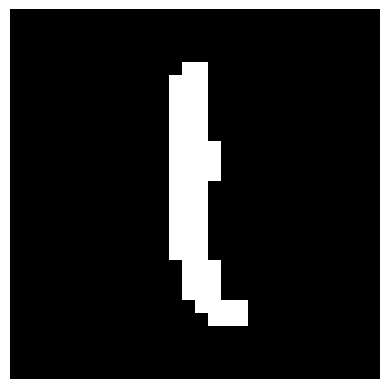

Input shape: (1, 784)
After Layer 1 (x1) shape: (1, 64)
After Layer 1:
[[-142   88 -225 -202 -203 -125  204 -205   60 -129 -266 -295   70  -75
   -14  199  204  -37 -314   74   -3  -80  -47  -58  287 -280  -10   34
  -263  154   15 -366   20  -74 -172 -215 -219 -117 -178 -100 -122 -274
   -95 -127   99 -367  206  196 -187 -160 -350 -145 -157  -48  -85 -148
    30 -115 -157 -245   20 -396 -295   11]]
After ReLU (x1) shape: (1, 64)
After ReLU (x1):
[[  0  88   0   0   0   0 204   0  60   0   0   0  70   0   0 199 204   0
    0  74   0   0   0   0 287   0   0  34   0 154  15   0  20   0   0   0
    0   0   0   0   0   0   0   0  99   0 206 196   0   0   0   0   0   0
    0   0  30   0   0   0  20   0   0  11]]
After Layer 2 (x2) shape: (1, 64)
After Layer 2:
[[  7527   1595 -14981  -1680   3770  13914   1898  -1957   8310  -4052
    1475  16045 -12030  13079 -16870   9688  17176   4034  -9999   3242
  -10207 -10868   5467  -6824  -9165   3182  -1823   8461  -4785  -5101
    -383  -4084   

In [89]:
# Assuming X_train, matrices, and output are defined
sample_idx = 400
sample = X_train[sample_idx:sample_idx+1]  # Select the 6th sample

x = sample
visualize_digit(x)

# Convert tensor to numpy and cast to int64 for matrix multiplication
x = x.numpy().astype(np.int64)

print(f"Input shape: {x.shape}")

# Layer 1: (1,784) @ (784,128) -> (1,128)
x1 = x @ matrices['matrix1']  # Matrix multiplication
print(f"After Layer 1 (x1) shape: {x1.shape}")
print("After Layer 1:")
print(x1)

# ReLU activation
x1 = np.maximum(0, x1)  # ReLU
print(f"After ReLU (x1) shape: {x1.shape}")
print("After ReLU (x1):")
print(x1)

# Layer 2: (1,128) @ (128,128) -> (1,128)
x2 = x1 @ matrices['matrix2']  # Matrix multiplication
print(f"After Layer 2 (x2) shape: {x2.shape}")
print("After Layer 2:")
print(x2)

# ReLU activation
x2 = np.maximum(0, x2)  # ReLU
print(f"After ReLU (x2) shape: {x2.shape}")
print("After ReLU (x2):")
print(x2)

# Layer 3: (1,128) @ (128,64) -> (1,64)
x3 = x2 @ matrices['matrix3']  # Matrix multiplication
print(f"After Layer 3 (x3) shape: {x3.shape}")
print("After Layer 3:")
print(x3)

# ReLU activation
x3 = np.maximum(0, x3)  # ReLU
print(f"After ReLU (x3) shape: {x3.shape}")
print("After ReLU (x3):")
print(x3)

# Layer 4: (1,64) @ (64,10) -> (1,10)
x4 = x3 @ matrices['matrix4']  # Matrix multiplication
print(f"After Layer 4 (x4) shape: {x4.shape}")
print("After Layer 4:")
print(x4)

# Output logits
output = x4
print(f"Output shape: {output.shape}")
print("\nOutput logits:")
print(output)

# Predicted class
predicted_class = np.argmax(output)
print("\nPredicted class:", predicted_class)